In [1]:
from glob import glob
import xarray as xr

In [2]:
path_to_data = '/home/samin/data/FVCOME_OUTPUT/Gldata/*.nc'

the following function work when we wanna read many files

In [6]:
drop_variables=['siglay','siglev']
def read_netcdfs(files, dim, transform_func= None):
    def process_one_path(path):
        # use a contex manager, to ensure the file gets closed after use
        with xr.open_dataset(path,decode_times= False, drop_variables=['siglay','siglev']) as ds:
            # transform_func should do some sort of selection or
            # aggregation
            if transform_func is not None: 
                ds = transform_func(ds)
            #load alll data from the transformed dataset, to ensure we can
            # use it after closing each original file 
            ds.load()
            return ds
    paths = sorted(glob(files))
    datasets = [process_one_path(p) for p in paths]
    combined = xr.concat(datasets, dim)
    return combined
    # here we suppose we only care about the combined mean of each file;
    # you might also use indexing operations like .sel to subset datasets   

In [7]:
combined = read_netcdfs('/home/samin/data/FVCOME_OUTPUT/Gldata/081700_0001.nc', dim ='time',
                        transform_func=lambda ds:ds.mean())


KeyboardInterrupt



In [11]:
drop_variables=['siglay','siglev']
ds = xr.open_dataset('/home/samin/data/FVCOME_OUTPUT/Gldata/FVCOMEDATA/fvcome_houron_estuary_fvcome_houron_estuary_nos.lmhofs.fields.n000.20230103.t06z.nc', decode_times= False, drop_variables=drop_variables)

In [12]:
time = ds.variables['Times'][:]
time.values[:]

array([b'2023-01-03T00:00:00.000000'], dtype='|S26')

# Required imports


In [1]:
# Required imports
from collections import namedtuple
import numpy as np
import datetime
from netCDF4 import Dataset
import configparser
from matplotlib import pyplot as plt
from cftime import num2pydate
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from pylag.regrid import regridder
from pylag.processing.ncview import Viewer
from pylag.processing.plot import FVCOMPlotter
from pylag.processing.plot import create_figure
from pylag.processing.utils import get_grid_bands

# Create initial position file

In [2]:
import os
data_dir = '/home/samin/data/FVCOME_OUTPUT/Gldata'.format(os.environ['HOME'])
from pylag.processing.coordinate import get_epsg_code, utm_from_lonlat, lonlat_from_utm
from pylag.processing.release_zone import create_release_zone
from pylag.processing.input import create_initial_positions_file_single_group

# Keep a copy of the cwd
cwd = os.getcwd()
# Create run directory
simulation_dir = '/home/samin/data/FVCOME_OUTPUT/simulations/horon'.format(cwd)
try:
    os.makedirs(simulation_dir)
except FileExistsError:
    pass

# The group ID of this particle set
group_id = 1

# Lat and lon coordiantes for the centre of the release zone
#lat = 45.6342671
#lon = 275.790956
lat = 45.6394448
lon = 275.80146279999997

# Convert to UTM coordinates
#epsg_code = get_epsg_code(lon, lat)
#epsg_code = '4978' # Geocentric coordinate system for World/cartesian
#easting, northing, _ = utm_from_lonlat([lon], [lat], epsg_code=epsg_code)

# Release zone radius (degree)
radius = 0.01

# Target number of particles to be released. Only a target,
# since we are evenly distributing particles in the release
# zone, which has no unique solution.
n_particles_target = 100

# Release depths
depth_below_surface = 0.0

# Create the release zone
surface_release_zone = create_release_zone(group_id = group_id,
                                           radius = radius,
                                           centre = [lon, lat],
                                           n_particles = n_particles_target,
                                           depth = depth_below_surface,
                                           random = False)

# Get the actual number of particles
n_particles = surface_release_zone.get_number_of_particles()

# Create input sub-directory
input_dir =  '{}/input'.format(simulation_dir)
try:
    os.makedirs(input_dir)
except FileExistsError:
    pass

# Output filename
file_name = '{}/initial_positions_huron.dat'.format(input_dir)

# Write data to file
create_initial_positions_file_single_group(file_name,
                                           n_particles,
                                           group_id,
                                           surface_release_zone.get_eastings(),
                                           surface_release_zone.get_northings(),
                                           surface_release_zone.get_depths())

In [3]:
from pylag.grid_metrics import create_fvcom_grid_metrics_file

# An example FVCOM output file
fvcom_file_name = '/home/samin/data/FVCOME_OUTPUT/Gldata/fvcome_houron_estuary_081700_0001.nc'

# The file listing the location of open boundary nodes
#obc_file_name = '/home/samin/data/FVCOME_OUTPUT/fvcom_tamar_estuary_obc.dat'
obc_file_name = '/home/samin/data/FVCOME_OUTPUT/obc.dat'
# The name of the output file
#grid_metrics_file_name = f'{input_dir}/grid_metrics_huron2.nc'
grid_metrics_file_name = f'{input_dir}/grid_metrics_huron_node3.nc'
# Generate the file
create_fvcom_grid_metrics_file(fvcom_file_name, obc_file_name = obc_file_name,
                               grid_metrics_file_name=grid_metrics_file_name)

Creating FVCOM grid metrics file /home/samin/data/FVCOME_OUTPUT/simulations/horon/input/grid_metrics_huron_node3.nc
INFO - detected longitudes greater than 180.0 in variable lon. Assuming longitude limits are in the range 0 - 360. Correcting these to be in the range -180 to 180.
INFO - detected longitudes greater than 180.0 in variable lonc. Assuming longitude limits are in the range 0 - 360. Correcting these to be in the range -180 to 180.
Grid has 51110 nodes on the open boundary


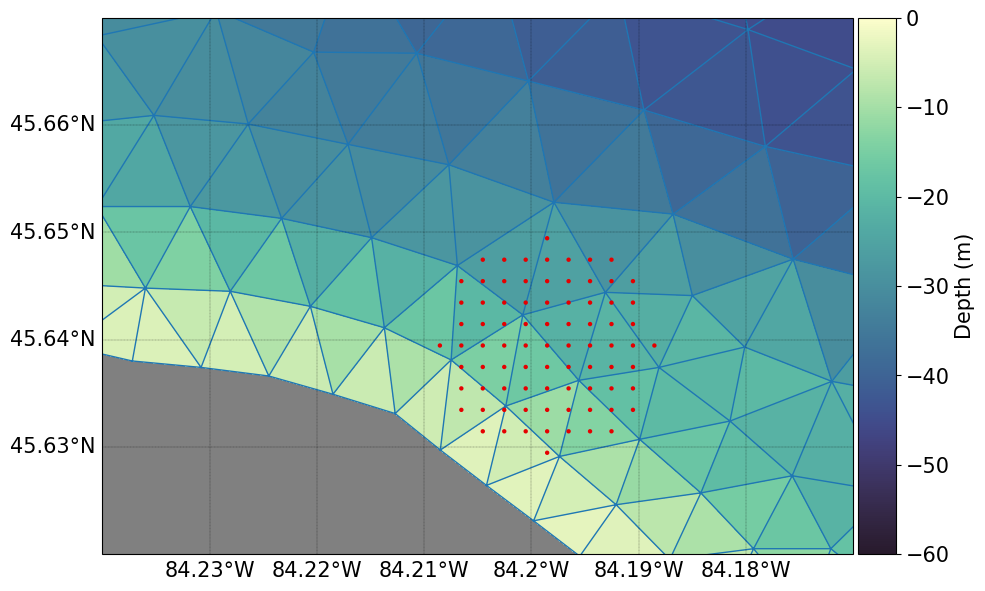

In [4]:
# getting lons and lats
from pylag.processing.plot import FVCOMPlotter
from pylag.processing.plot import create_figure, colourmap

#lons, lats = lonlat_from_utm(surface_release_zone.get_eastings(),
                             #surface_release_zone.get_northings(),
                           # epsg_code=epsg_code)
lons = surface_release_zone.get_eastings()
lats = surface_release_zone.get_northings()
# Create figure
font_size = 15
cmap = colourmap('h_r')
fig, ax = create_figure(figure_size=(26., 26.), projection=ccrs.PlateCarree(),
                       font_size=font_size, bg_color='gray')


#Grid metrics file name
#grid_metrics_file_name = f"{input_dir}/grid_metrics_huron2.nc"
#grid I created with new nodes
grid_metrics_file_name = f"{input_dir}/grid_metrics_huron_node3.nc"
# Read in the bathymetry
ds = Dataset(grid_metrics_file_name, 'r')
bathy = -ds.variables['h'][:]
ds.close()
del(ds)

# Configure plotter
plotter = FVCOMPlotter(grid_metrics_file_name,
                       geographic_coords=True,
                       font_size=font_size)

# Plot bathymetry
extents = np.array([275.76,275.83, 45.62,45.67], dtype=float)
#extensts = np.array([-84,-81.3, 43,46], dtype=float)
ax, plot = plotter.plot_field(ax, bathy, extents=extents, add_colour_bar=True, cb_label='Depth (m)',
                              vmin=-60., vmax=0.0, cmap=cmap)

# Overlay grid
plotter.draw_grid(ax, linewidth=1.0)

# Plot particle initial positions
scatter = plotter.scatter(ax, lons, lats, s=10, color='#e50000', edgecolors='none')
#plt.savefig('/home/samin/data/figs/initial_position_water.jpg')

In [5]:
import configparser
config_file_name = '/home/samin/data/FVCOME_OUTPUT/confings/huron2.cfg'


cf = configparser.ConfigParser()
cf.read(config_file_name)

# Start time
print('Start time: {}'.format(cf.get('SIMULATION', 'start_datetime')))

# End time
print('End time: {}'.format(cf.get('SIMULATION', 'end_datetime')))

# Specify that this is a forward tracking experiment
print('Time direction: {}'.format(cf.get('SIMULATION', 'time_direction')))

# We will do a single run, rather than an ensemble run
print('Number of particle releases: {}'.format(cf.get('SIMULATION', 'number_of_particle_releases')))

# Use depth restoring, and restore particle depths to the ocean surface
print('Use depth restoring: {}'.format(cf.get('SIMULATION', 'depth_restoring')))
print('Restore particles to a depth of: {} m'.format(cf.get('SIMULATION', 'fixed_depth')))

# Specify that we are working with FVCOM in cartesian coordinates
print('Model name: {}'.format(cf.get('OCEAN_DATA', 'name')))
print('Coordinate system: {}'.format(cf.get('SIMULATION', 'coordinate_system')))

# Set the location of the grid metrics and input files
print('Data directory: {}'.format(cf.get('OCEAN_DATA', 'data_dir')))
print('Path to grid metrics file: {}'.format(cf.get('OCEAN_DATA', 'grid_metrics_file')))
print('File name stem of input files: {}'.format(cf.get('OCEAN_DATA', 'data_file_stem')))
      
# Do an advection only run using a RK$ intergration scheme 
print('Numerical method: {}'.format(cf.get('NUMERICS', 'num_method')))
print('Iterative method: {}'.format(cf.get('NUMERICS', 'iterative_method')))

Start time: 2023-08-16 15:00:00
End time: 2023-08-21 00:00:00
Time direction: forward
Number of particle releases: 10
Use depth restoring: True
Restore particles to a depth of: 0.0 m
Model name: FVCOM
Coordinate system: geographic
Data directory: /home/samin/data/FVCOME_OUTPUT/Gldata
Path to grid metrics file: /home/samin/data/FVCOME_OUTPUT/simulations/horon/input/grid_metrics_huron_node3.nc
File name stem of input files: fvcome_houron_estuary_08
Numerical method: standard
Iterative method: Adv_RK4_3D


In [7]:
cf.set('OCEAN_DATA', 'data_dir', data_dir)
cf.set('OCEAN_DATA', 'grid_metrics_file', grid_metrics_file_name)

# Save a copy in the simulation directory
with open(f"{simulation_dir}/pylag.cfg", 'w') as config:
    cf.write(config)

In [8]:
# Change to the run directory
os.chdir(f"{simulation_dir}")

# Run the model
!{"python -m pylag.main -c pylag.cfg"}

# Return to the cwd
os.chdir(cwd)


Starting ensemble member 1 ...
Progress:
100% |###########################################|

Starting ensemble member 2 ...
Progress:
100% |###########################################|

Starting ensemble member 3 ...
Progress:
100% |###########################################|

Starting ensemble member 4 ...
Progress:
100% |###########################################|

Starting ensemble member 5 ...
Progress:
100% |###########################################|

Starting ensemble member 6 ...
Progress:
100% |###########################################|

Starting ensemble member 7 ...
Progress:
100% |###########################################|

Starting ensemble member 8 ...
Progress:
100% |###########################################|

Starting ensemble member 9 ...
Progress:
100% |###########################################|

Starting ensemble member 10 ...
Progress:
100% |###########################################|


In [136]:
directory = '/home/samin/data/FVCOME_OUTPUT/simulations/horon/output'

In [131]:
import os
file_name = []
for x in os.listdir(path):
     if x.endswith("nc"):
        # Prints only text file present in My Folder
        file_name.append(x)
        print(x)

pylag_4.nc
pylag_9.nc
pylag_1.nc
pylag_5.nc
pylag_6.nc
pylag_10.nc
pylag_3.nc
pylag_8.nc
pylag_2.nc
pylag_7.nc


In [153]:
from pathlib import Path
cwd = os.getcwd()
# Create run directory
path = "/home/samin/data/FVCOME_OUTPUT/simulations/horon/output"

os.chdir(path)
path = Path.cwd()  # insert your path 

files = []
for file in path.rglob(".nc"):  # loop recursively over all subdirectories
    files.append(file.name)

In [160]:
from pathlib import Path
path = Path('/home/samin/data/FVCOME_OUTPUT/simulations/horon/output')
files = [file.stem for file in path.rglob('nc')]
print(file)

['pylag_4.nc', 'pylag_9.nc', 'pylag_1.nc', 'pylag_5.nc', 'pylag_6.nc', 'pylag_out.cfg', 'pylag_10.nc', 'pylag_3.nc', 'pylag_8.nc', 'pylag_2.nc', 'pylag_7.nc', 'pylag_out.log']


In [116]:
path = '/home/samin/data/FVCOME_OUTPUT/simulations/horon/output/moredata'
# import OS module
import os
 
# Get the list of all files and directories
dir_list = os.listdir(path)
print("Files and directories in '", path, "' :")
# prints all files
print(dir_list)

Files and directories in ' /home/samin/data/FVCOME_OUTPUT/simulations/horon/output/moredata ' :
['pylag_4.nc', 'pylag_9.nc', 'pylag_1.nc', 'pylag_5.nc', 'pylag_6.nc', 'pylag_out.cfg', 'pylag_10.nc', 'pylag_3.nc', 'pylag_8.nc', 'pylag_2.nc', 'pylag_7.nc', 'pylag_out.log']


In [166]:
path = '/home/samin/data/FVCOME_OUTPUT/simulations/horon/output/moredata/*.nc*'
    

In [167]:
file_path = path
if os.path.exists(file_path):
    with open(file_path, 'r') as files:
        pass
else:
        print(f"The file '{file_path}' does not exist.")


The file '/home/samin/data/FVCOME_OUTPUT/simulations/horon/output/moredata/*.nc*' does not exist.


In [10]:
for file_name in os.listdir('/home/samin/data/FVCOME_OUTPUT/simulations/horon/output/moredata'):
    if file_name.endswith("nc"):
        print(sfile_name)

pylag_4.nc
pylag_9.nc
pylag_1.nc
pylag_5.nc
pylag_6.nc
pylag_10.nc
pylag_3.nc
pylag_8.nc
pylag_2.nc
pylag_7.nc


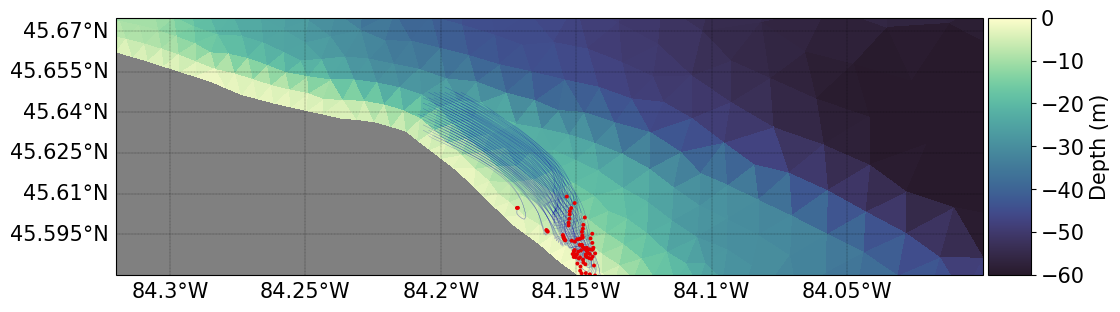

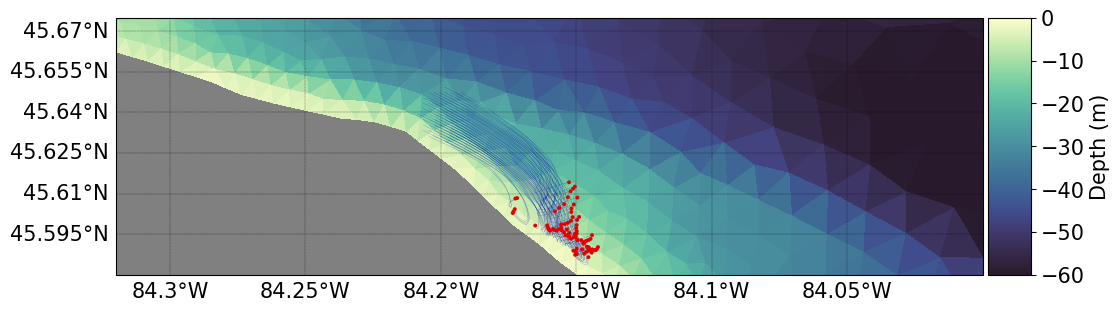

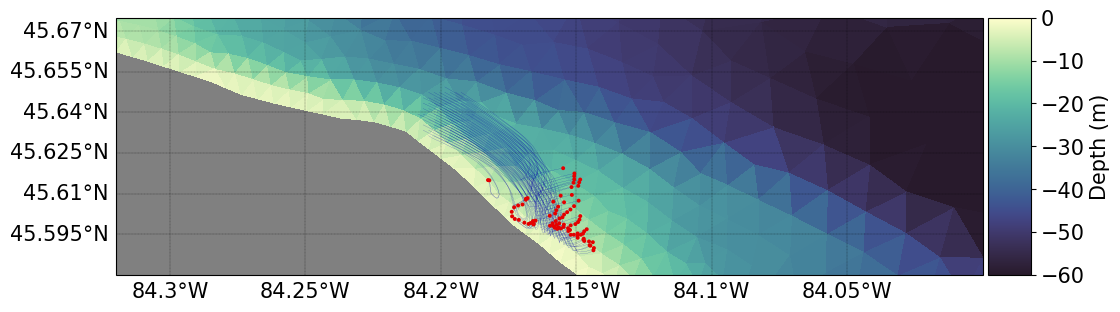

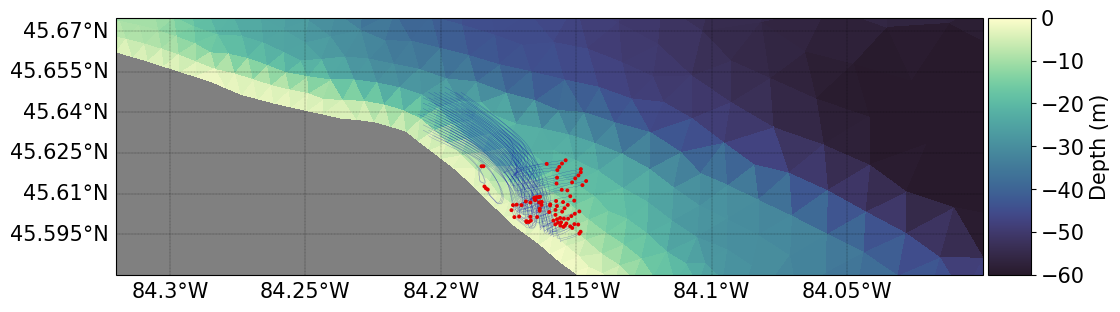

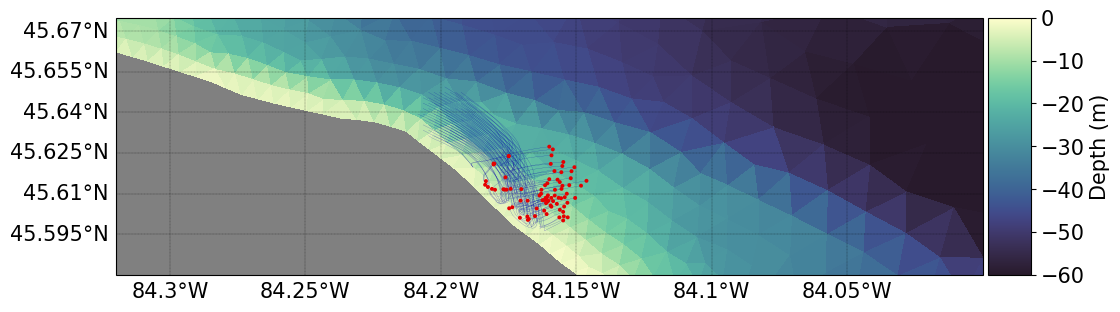

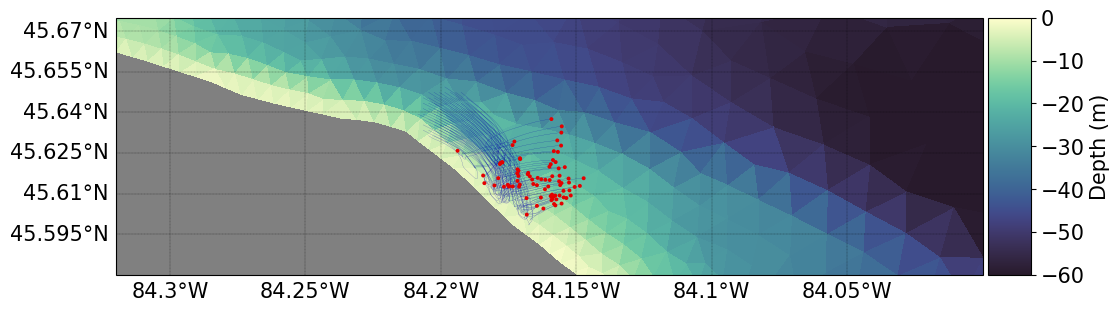

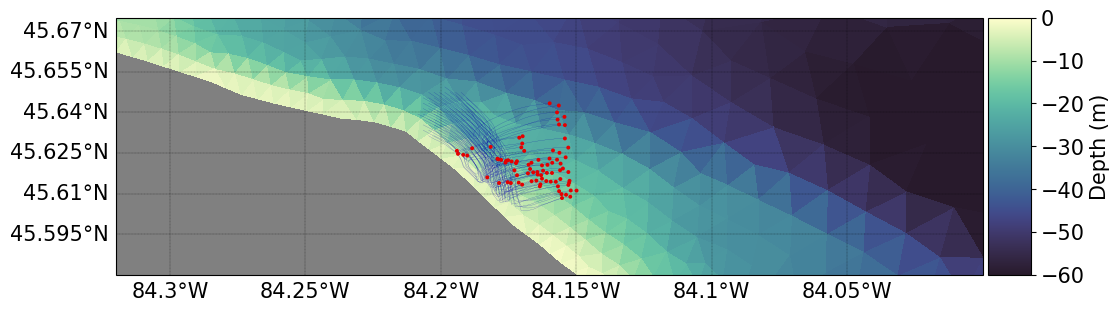

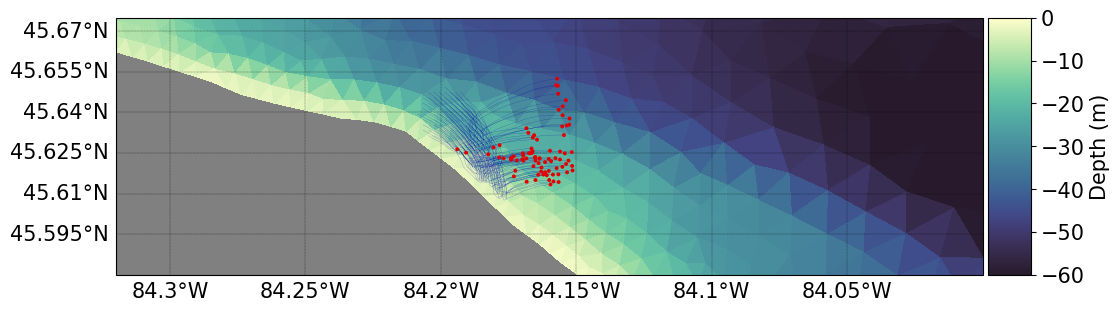

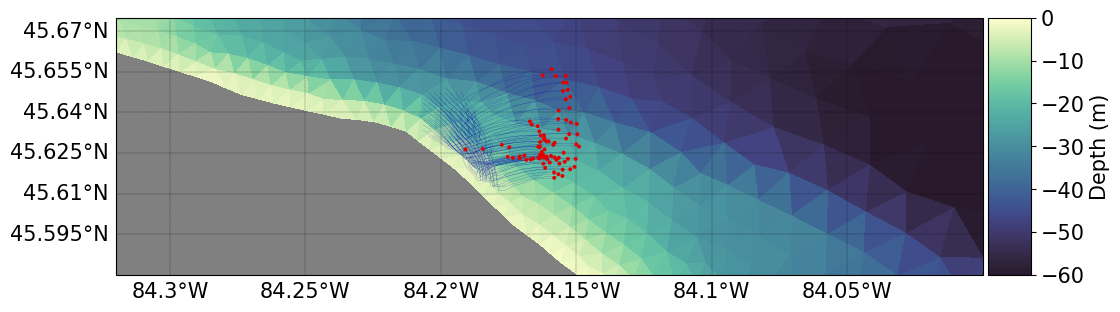

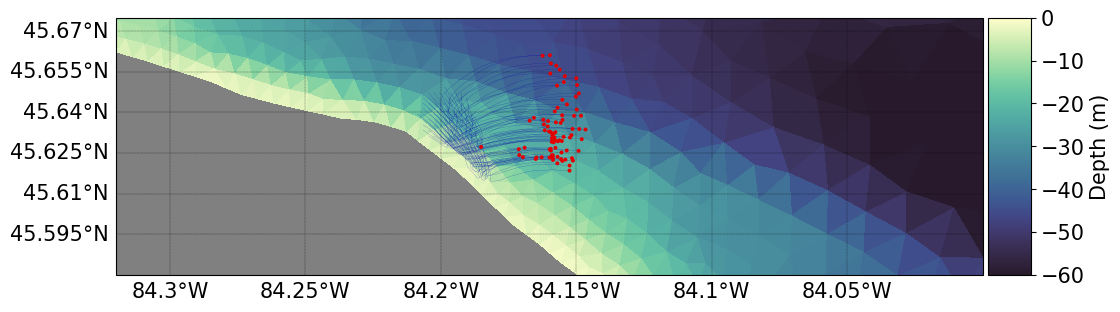

In [9]:
from datetime import timedelta

from pylag.processing.ncview import Viewer



#file_name = '/home/samin/data/FVCOME_OUTPUT/simulations/horon/output/moredata/pylag_3.nc'
for file_name in sorted(filter (lambda x : x.endswith("nc"),os.listdir('/home/samin/data/FVCOME_OUTPUT/simulations/horon/output/moredata')),key= lambda x : int(x.split(".")[0].split("_")[1])):
    #print(file_name)
    #continue
    #if file_name.endswith("nc"):
    sample_name = file_name
    file_name = '/home/samin/data/FVCOME_OUTPUT/simulations/horon/output/moredata/' + file_name 
    # Time of flight
    time_of_flight = timedelta(hours=12)
    font_size = 15
    # Plot extents
    extents = np.array([275.68, 276, 45.58, 45.675], dtype=float)
    #extents = np.array([-145, 245, 40, 46.4], dtype=float)
    fig, ax = create_figure(figure_size=(30., 30.), projection=ccrs.PlateCarree(),
                            font_size=font_size, bg_color='gray')

    # Configure plotter
    plotter = FVCOMPlotter(grid_metrics_file_name,
                           geographic_coords=True,
                           font_size=font_size)

    # Plot the bathymetry again. We'll overlay pathlines on top of this.
    plotter.plot_field(ax, bathy, extents= extents, add_colour_bar=True, cb_label='Depth (m)',
                       vmin=-60., vmax=0., cmap=cmap)

    # Dataset holding particle positions
    viewer = Viewer(file_name, time_rounding=900)

    # Get time index
    date = viewer.date[0] + time_of_flight
    time_index = viewer.date.tolist().index(date)
    n_times = viewer.date[:time_index+1].shape[0]

    # Convert positions into lons/lats
    #lons, lats = lonlat_from_utm(viewer('latitude')[time_index, :].squeeze(),
                                # viewer('longitude')[time_index, :].squeeze(), epsg_code=epsg_code)
    lons,lats = [viewer('longitude')[time_index,:].squeeze(), viewer('latitude')[time_index, :].squeeze()]

    # Plot particle final positions
    ax, scatter = plotter.scatter(ax, lons, lats, s=8, color='#e50000', edgecolors='none')

    # Convert all pathline coordinates into lons/lats
    #for i in range(0,60):
        #lons_paths, lats_paths = (viewer('longitude')[:i+1, :],
                                       # viewer('latitude')[:i+1, :])
    lons_paths, lats_paths = (viewer('longitude')[:time_index+1, :],
                                             viewer('latitude')[:time_index+1, :])
    # Add path lines
    ax, lines = plotter.plot_lines(ax, lons_paths, lats_paths, linewidth=0.10, alpha=1, color='#0504aa')
    output_directory = '/home/samin/data/figs/new_results/'
    # for i in range(1, 11):
    #     name = os.path.join(output_directory, f'figure_{i}.png')
    plt.savefig(output_directory+sample_name.split(".")[0]+ ".png",dpi=300)
        #plt.close